* John Galpin
* Professor Raff
* UMBC Data 690
* 5/8/2020

# **Introduction**
Welcome to my pong simulator! 

My goal when I started this project was to get two models that could play pong against eachother. The first model was meant to be a CNN and the second LSTM. The final results were very different than what I set out to do. This notebook shows the process I went through implementing two models. There is some important information if you are running this on google colab. Colab does not come with Pygame so it must be installed. Additionally Colab does not provide a video driver. Meaning the game can't be watched in real time on the server. If you would like to try set the display driver to 'dummy'. Code can and should be moved onto a local machine and run with display if this setting is removed. Important note about this project. I could not get Pygame to render correctly on google colab. I came to this conclusion by exporting images from the game display. This was done on my local machine with the same script. Google colab wouldn't render various object(ball, paddle and text). So I recommend running this code on your local machine.

In [2]:
!pip install pygame

     |████████████████████████████████| 11.4MB 8.1MB/s 


In [1]:
import math
import pygame
import random
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from sklearn.preprocessing import normalize
from scipy.ndimage import zoom,interpolation
#import torchvision.datasets as dsets
#import torchvision.transforms as transforms
from PIL import Image, ImageOps
import torch.nn.functional as F
import sys

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [0]:
#do not run if local
import os
os.environ['SDL_VIDEODRIVER']='dummy'

In [5]:
#do not run if local
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# **Set Up Game Parameters**

I did not write a majority of the code written in this section. You can find most of it written in the link below. I will provide a high level breakdown of the classes and functions.

www.programarcadegames.com/python_examples/f.php?file=pong.py



   The ball class defines the initial parameters like shape, position, speed and direction. Reset moves the ball back to starting position. Bounce updates the ball direction and speed after it touches a surface. The ball can only bounce off horizontal surfaces other than the side of a players paddle. Small changes were made to the code to prevent 90 degree bounces off walls. This prevents the ball from bouncing back and forth infinitely. If a player misses the ball it will appear on an alternating basis from behind one of the players. If the game resets the ball appears halfway between the players on the y axis and randomly on the x. Scoring is accomplished by making contact with the ball. A player wins by achieving a score differential greater than 3. The player class initializes the paddles starting and shape. The Y position is static for both paddles. The paddles move along the X axis.  The update function had to be changed from its initial implementation which used an actual joystick. The update function now takes the paddle object and a given numeric input to update the position. The update function multiplies the input by 15 to increase speed as the position is updated. The paddle is bounded by the vertical walls of the game. That functionality doesn't prevent the input from attempting to push the paddle outside the game display (and can do so without bounding rules).  




In [2]:
# Define some colors
BLACK = (0 ,0, 0)
WHITE = (255, 255, 255)
 
 
# This class represents the ball
# It derives from the "Sprite" class in Pygame
class Ball(pygame.sprite.Sprite):
 
    # Constructor. Pass in the color of the block, and its x and y position
    def __init__(self):
        # Call the parent class (Sprite) constructor
        super().__init__()
 
        # Create the image of the ball
        self.image = pygame.Surface([10, 10])
 
        # Color the ball
        self.image.fill(WHITE)
 
        # Get a rectangle object that shows where our image is
        self.rect = self.image.get_rect()
 
        # Get attributes for the height/width of the screen
        self.screenheight = pygame.display.get_surface().get_height()
        self.screenwidth = pygame.display.get_surface().get_width()
 
        # Speed in pixels per cycle
        self.speed = 0
 
        # Floating point representation of where the ball is
        self.x = 0
        self.y = 0
 
        # Direction of ball in degrees
        self.direction = 0
 
        # Height and width of the ball
        self.width = 10
        self.height = 10
 
        # Set the initial ball speed and position
        self.reset()
 
    def reset(self):
        self.x = random.randrange(50,750)
        self.y = 350.0
        self.speed=8.0
 
        # Direction of ball (in degrees)
        self.direction = random.randrange(-45,45)
 
        # Flip a 'coin'
        if random.randrange(2) == 0 :
            # Reverse ball direction, let the other guy get it first
            self.direction += 180
            self.y = 50
 
    # This function will bounce the ball off a horizontal surface (not a vertical one)
    def bounce(self,diff):
        self.direction = (180-self.direction)%360
        self.direction -= diff
 
        # Speed the ball up
        self.speed *= 1.1
 
    # Update the position of the ball
    def update(self):
        # Sine and Cosine work in degrees, so we have to convert them
        direction_radians = math.radians(self.direction)
 
        # Change the position (x and y) according to the speed and direction
        self.x += self.speed * math.sin(direction_radians)
        self.y -= self.speed * math.cos(direction_radians)
 
        if self.y < 0:
            self.reset()
 
        if self.y > 600:
            self.reset()
 
        # Move the image to where our x and y are
        self.rect.x = self.x
        self.rect.y = self.y
 
        # Do we bounce off the left of the screen?
        if self.x <= 0:
            self.direction = (360-self.direction)%360
            if self.direction==90:
                self.direction=90+5
            
            #print(self.direction)
            #self.x=1
 
        # Do we bounce of the right side of the screen?
        if self.x > self.screenwidth-self.width:
            self.direction = (360-self.direction)%360
            if self.direction==-90:
                self.direction=-90-5

 
# This class represents the bar at the bottom that the player controls
class Player(pygame.sprite.Sprite):
    # Constructor function
    def __init__(self, joystick, y_pos):
        # Call the parent's constructor
        super().__init__()
 
        self.width=75
        self.height=15
        self.image = pygame.Surface([self.width, self.height])
        self.image.fill(WHITE)
        self.joystick = joystick
 
        # Make our top-left corner the passed-in location.
        self.rect = self.image.get_rect()
        self.screenheight = pygame.display.get_surface().get_height()
        self.screenwidth = pygame.display.get_surface().get_width()
 
        self.rect.x = 400
        self.rect.y = y_pos
 
    # Update the player. Function receives prediction
    def update(self,pred):

 
        # Change update function to get output self.joystick, self.joystick will be dictated by deterministic or Neural Net
        #prediction needs to be -1 or 1
        self.joystick=pred
        horiz_axis_pos= self.joystick         #self.joystick.get_axis(0)
 
        # Move x according to the axis. We multiply by 15 to speed up the movement.
        self.rect.x=int(self.rect.x+horiz_axis_pos*15)
 
        # Make sure we don't push the player paddle off the right side of the screen
        if self.rect.x > self.screenwidth - self.width:
            self.rect.x = self.screenwidth - self.width
            
        elif self.rect.x < 0:
            self.rect.x = 0
 


# **Backboard**

This constitutes the labeling and backboarding function. The backboarding function takes the paddle and the ball as inputs. It simply returns whether or not the ball is higher, lower or equal to the given paddle based on the X axis positions. This function does tend to slightly lag behind the ball movement. This is because balls ability to appear in different spots on the game screen(outlined above). Providing the actual X distance instead didn't prove to be an effective alternative for regression for labeling. This current function is overly simplistic for regression based models and is set up for labeling classification. The function works well when training a model because it never misses the ball.

In [3]:
def Backboard(paddle,ball):
  #height=base  x sin(first base angle) x sin(second base angle)/sin(first base angle + second base angle)
  if ball.rect.x>paddle.rect.x:
    return 1
  elif ball.rect.x<paddle.rect.x:
    return -1
  else:
    return 0
   

# **CNN**

**My first model!**

Convolutional networks are good for image processing so why not start there. I knew I wanted to make the model atleast 4 convolutions deep and return a single value. Eventually I moved to classification model. Reasoning will be provided in sections below. The number of convolutional layers isn't arbitrary. I needed something lightweight but was complex enough to detect the ball movement. Thus I included max pooling to reduce dimensionality. Part way through I switch the decision function to Leaky Relu to avoid loss of gradient. Loss the function is cross entropy loss because it is better suited to classification.

In [4]:
class Paddle_CNN(nn.Module):
    def __init__(self):
        super(Paddle_CNN, self).__init__()
        self.conv1=nn.Conv2d(3, 64, 5)
        self.pool1=nn.MaxPool2d(2, 2)
        self.relu1=nn.LeakyReLU()
        self.conv2=nn.Conv2d(64,256, 5)
        self.pool2=nn.MaxPool2d(2, 2)
        self.relu2=nn.LeakyReLU()
        #self.drop1=nn.Dropout(.2)
        self.conv3=nn.Conv2d(256,64,5)
        self.pool3=nn.MaxPool2d(2, 2)
        self.rulu3=nn.LeakyReLU()
        self.conv4=nn.Conv2d(64,3,5)
        self.relu4=nn.LeakyReLU()
        self.flat=nn.Flatten()
        self.fc1=nn.Linear(562,230)
        self.fc2 = nn.Linear(230,115)
        self.fc3 = nn.Linear(115,3)
        self.soft=nn.Softmax()

    def forward(self, x,y):
        x = self.pool1(F.leaky_relu(self.conv1(x),.01))
        x = self.pool2(F.leaky_relu(self.conv2(x),.01))
        #x = self.drop1(x)
        x = self.pool3(F.leaky_relu(self.conv3(x),.01))
        x = F.leaky_relu(self.conv4(x),.01) 
        x = self.flat(x)
        #print(x.shape)
        #print(y.shape)
        x = torch.cat((x, y), dim=1)
        x = F.leaky_relu(self.fc1(x),negative_slope=0.01)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.soft(x)
        return x

In [5]:
cnn=Paddle_CNN()

In [6]:
LR=.00001
#cnn.cuda()  
optimizer = torch.optim.Adam(cnn.parameters(),lr=LR)   # optimize all cnn parameters
criterion = nn.CrossEntropyLoss()


In [0]:
#imgdata = pygame.surfarray.pixels3d()

**Training**

The code below executes the game and runs training at the same time. All the objects are initialized and the game board is set. The training is set in a loop for X number of games. The game itself is a loop that runs until the exit_program flag is hit. There was actually a bug in the code that cause the final score output to higher than normal. Player and ball positions are not updated while the game times out. But scoring ran regardless and is computed based on object positions. Since the object positions cannot be updated when a score differential greater than 3 is reached. The score was run up for the winning player. I fixed this by reducing the game timeout. Regardless, loss is computed under the same section as paddle movement and is cannot be reached during the extra frame iterations. So the model was never affected by the bug.

Major additions to the arcade code are made to fit the network operations. The network is set up to receive the game surface array as a single batch shape B,C,H,W([1,3,200,150]) and the paddles x axis position. Paddle 1 receives predictions from the network as a single value. The label provided by the backboarding function and is converted to a 1D tensor. The classification model then outputs 3 values. Then I use argmax and convert it back to its original label instead of the label index. Paddle two receives output from the backboarding function and follows the ball around. More explanation available after the code below.

In [ ]:
#Set whole thing in training loop for pytorch
#CNN Training

game_count=1
num_games=1
Game_Accuracy=[]

while game_count<=num_games:
      print("Progress"+str(game_count)+"/"+str(num_games))
      game_count+=1
      
      

      score1 = 0
      score2 = 0
      
      # Call this function so the Pygame library can initialize itself
      pygame.init()
      
      # Create an 800x600 sized screen
      screen = pygame.display.set_mode([800, 600])
      
      # Set the title of the window
      pygame.display.set_caption('Pong')
      
      # Enable this to make the mouse disappear when over our window
      pygame.mouse.set_visible(0)
      
      # This is a font we use to draw text on the screen (size 36)
      font = pygame.font.Font(None, 36)
      
      # Create a surface we can draw on
      background = pygame.Surface(screen.get_size())
      
      # Create the ball
      ball = Ball()
      # Create a group of 1 ball (used in checking collisions)
      balls = pygame.sprite.Group()
      balls.add(ball)



      """
      #set joysticks to receive integers from neural network or deterministic. Possibly initialize to 0?
      """ 
      joystick1=0
      joystick2=0
      # Create the player paddle object
      player1 = Player(joystick1,580)
      player2 = Player(joystick2,25)

      movingsprites = pygame.sprite.Group()
      movingsprites.add(player1)
      movingsprites.add(player2)
      movingsprites.add(ball)

      clock = pygame.time.Clock()
      done = False
      exit_program = False
      i=0
      y=1
      try:
          if Accuracy>.6:
                break
      except:
          pass
      Accuracy=0
      while not exit_program:
          i+=1

          # Clear the screen
          screen.fill(BLACK)

          for event in pygame.event.get():
              if event.type == pygame.QUIT:
                  exit_program = True

          # Stop the game if there is an imbalance of 3 points
          if abs(score1 - score2) > 3:
              done = True
              

          if not done:
              # Update the player and ball positions, receives neural net prediction
              

              
              
              if i>1:
                #print(pred1[0].cpu().detach().numpy())
                pred1=np.argmax(pred1[0].cpu().detach().numpy())
                #print("Arg pos: "+str(pred1))
                if pred1==0:
                    pred1=-1
                elif pred1==1:
                    pred1=0
                else:
                    pred1=1
                    
                if pred1==target:
                    y+=1
                Accuracy=y/i
                print("Target: "+str(target))
                print("Prediction: "+str(pred1))
                print("Accuracy: "+str(Accuracy))
                #update positions
                player1.update(pred1)
                player2.update(pred2)
                ball.update()
                print(ball.direction)
              
              #Uncomment if running on local
              """
              if i%100==0:
                print("Player1 position: "+str(player1.rect.x))
                print("Player2 position: "+str(player2.rect.x))
                print("Ball position: "+str(ball.rect.x)+", "+str(ball.rect.y))
                print(score1)
                print(score2)
              elif abs(player1.rect.y-ball.rect.y)<50:
                print("Player1 position: "+str(player1.rect.x))
                print("Player2 position: "+str(player2.rect.x))
                print("Ball position: "+str(ball.rect.x)+", "+str(ball.rect.y))"""

          # If we are done, print game over
          if done:
              text = font.render("Game Over", 1, (200, 200, 200))
              textpos = text.get_rect(centerx=background.get_width()/2)
              textpos.top = 50
              screen.blit(text, textpos)

          # See if the ball hits the player paddle
          if pygame.sprite.spritecollide(player1, balls, False):
              # The 'diff' lets you try to bounce the ball left or right depending where on the paddle you hit it
              diff = (player1.rect.x + player1.width/2) - (ball.rect.x+ball.width/2)

              # Set the ball's y position in case we hit the ball on the edge of the paddle
              ball.y = 570
              ball.bounce(diff)
              score1 += 1

          # See if the ball hits the player paddle
          if pygame.sprite.spritecollide(player2, balls, False):
              # The 'diff' lets you try to bounce the ball left or right depending where on the paddle you hit it
              diff = (player2.rect.x + player2.width/2) - (ball.rect.x+ball.width/2)

              # Set the ball's y position in case we hit the ball on the edge of the paddle
              ball.y = 40
              ball.bounce(diff)
              score2 += 1

          # Print the score
          scoreprint = "Player 1: "+str(score1)
          text = font.render(scoreprint, 1, WHITE)
          textpos = (0, 0)
          screen.blit(text, textpos)

          scoreprint = "Player 2: "+str(score2)
          text = font.render(scoreprint, 1, WHITE)
          textpos = (300, 0)
          screen.blit(text, textpos)

          # Draw Everything
          movingsprites.draw(screen)

          # Update the screen 
          pygame.display.flip()
          if not done:    
              #capture image for network 
              screen.lock()
              img = pygame.surfarray.array3d(screen)
              screen.unlock()
              #Resize
              img=interpolation.zoom(img,[.25,.25,1])
              #Normalize
              img = np.true_divide(img,255)
              #To Tensor and reshape
              img=torch.tensor(img)
              img=torch.unsqueeze(img,0)
              img=img.permute(0,3,1,2)
              img=img.float()
              pos=torch.tensor([player1.rect.x])
              pos=torch.unsqueeze(pos,0).float()
              #player1
              optimizer.zero_grad()
              # forward + backward + optimize
              pred1=cnn(img,pos).type(torch.float64)
              label=Backboard(player1,ball)
              target=label
              if label==-1:
                  label=0
              elif label==0:
                  label=1
              elif label==1:
                  label=2
              label = torch.tensor([label],dtype=torch.float64)
              label=label.type(torch.LongTensor)
              #print(label)
              loss = criterion(pred1, label)
              loss.backward()
              optimizer.step()
              last=ball.rect.x
            
              #player2 backboard pred2
              pred2=Backboard(player2,ball)
          
          if done:
            print("Gameover")
            Game_Accuracy.append(Accuracy)
            #clock.tick(5)
            if score1>score2:
                print("Player 1 Score: "+str(score1-1))
                print("Player 2 Score: "+str(score2))
            elif score1<score2:
                print("Player 1 Score: "+str(score1))
                print("Player 2 Score: "+str(score2-1))
            #print(loss)
            #pygame.quit()
            exit_program = True

In [13]:
print(Game_Accuracy)

[]


In [29]:
#save model
torch.save(cnn,'CNN_Paddle.ml')

C:\Users\John Galpin\anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Paddle_CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\John Galpin\anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\John Galpin\anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MaxPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\John Galpin\anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LeakyReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It w

# Improving Model Performance

Getting the first model to run correctly was certainly a trial. I learned a ton a long the way. Even if there wasn't a huge shift in validation performance. 

The first big changes were made to the input. Aside from the game not rendering correctly on colab. I was making one major mistake while training the model. I was feeding it the game array with only the black screen rendered before object were placed on the screen. All elements are rendered and updated at the bottom of the game loop. The is where I capture the game array. There are two major transformations I do on the game array. First I resize the game to be a quarter of its original size. When I moved to code onto my local machine I didn't have GPU support. Training this first model took almost 5 hours. This trick drastically reduced training time by 80%. The second major transformation was normalizing the color values in the array. Non normalized data was contributing to the outputs averaging the array input(bad). The second major change to input was the players paddle X axis position. I decided the model should be allowed to know its own positions. This had a huge positive impact on the model performance from a vizual standpoint. Prior to that change the paddle would swing wildly across the screen in the correct general direction causing the paddle to have massive over corrections. Giving the models its position seemed to reduce this pendulum effect.

The next round of changes was done to the model itself. The first major change was moving from a regression based model to a classification model. I think a regression model would have work but other problems early on caused me to move away from this model. The major reason behind this shift is my labeling function is really suited to a classification style model. With that decision I had to switch to Cross Entropy Loss and softmax as my final activation. Both of which are better suited for multi classification tasks. Yet after all these changes I was still experience repeating output even on training. First I lowered the learning rate on Adam, anything above 1e-4 would cause repeating output. Additionally, I realized the model was experience dying ReLu's. When those layers were switched to leaky versions the change was night and day. Lastly I allow the model to see it own position. I concat this input to a linear layer near the bottom of the forward network. There were a few model changes that didn't stick. At one point I tried implementing dropout layers. Overall having any drop out layers at all cause the model to drop accuracy on average by 10%. I suspect if the batch sizes were bigger and with a higher learning rate, a dropout layer would be helpful.

I implement two counters, one for total frames and another for correct answers. This gives real time accuracy and accuracy at the end of each game. The best the model pushed for was usually between 55%-59%. The model outputs 3 classes but in reality the frequency that the target is 0(paddle not moving) is extremely low compared to moving up and down the screen. So random guessing sits much closer to 50%. Meaning the model performance is not satisfactory. During training the model eventually locks onto the player 2 paddle which directly recevies the label. While this logic is favorable the model will always eventually out of step. The biggest issue I noticed during training was sticky outputs. This behavior occurred whenever the model would have to correct its position and cross the screen. This would cause the model to over correct and continuously output the same value for awhile. 

# **Model 1 Test Standalone**

Unfortunately the model consistently fell apart in various configurations when I moved to validation. I thought all the changes I made above on training would imact validation performance. I use a very similar set up below as I did above. I just remove the training operations and put the model in evaluation. The model will output one class as favorable. Within the first few frames the paddle is jammed against one side on the screen. Since the model never really breaks out of random guessing, the model most likely just locks onto on of the labels. Logically speaking in the context of the game the overall distribution of moving up or down the screen is 50/50. Making the question posed to the network poorly defined. Armed with the knowledge above we will try a different approach for the second model.

In [5]:
paddle1=torch.load('CNN_Paddle.ml')
#paddle1.cuda()
paddle1=paddle1.eval()
#paddle1.training

In [ ]:
#Set whole thing in training loop for pytorch
#CNN Training

game_count=1
num_games=1
Game_Accuracy=[]

while game_count<=num_games:
      print("Progress"+str(game_count)+"/"+str(num_games))
      game_count+=1
      
      

      score1 = 0
      score2 = 0
      
      # Call this function so the Pygame library can initialize itself
      pygame.init()
      
      # Create an 800x600 sized screen
      screen = pygame.display.set_mode([800, 600])
      
      # Set the title of the window
      pygame.display.set_caption('Pong')
      
      # Enable this to make the mouse disappear when over our window
      pygame.mouse.set_visible(0)
      
      # This is a font we use to draw text on the screen (size 36)
      font = pygame.font.Font(None, 36)
      
      # Create a surface we can draw on
      background = pygame.Surface(screen.get_size())
      
      # Create the ball
      ball = Ball()
      # Create a group of 1 ball (used in checking collisions)
      balls = pygame.sprite.Group()
      balls.add(ball)



      """
      #set joysticks to receive integers from neural network or deterministic. Possibly initialize to 0?
      """ 
      joystick1=0
      joystick2=0
      # Create the player paddle object
      player1 = Player(joystick1,580)
      player2 = Player(joystick2,25)

      movingsprites = pygame.sprite.Group()
      movingsprites.add(player1)
      movingsprites.add(player2)
      movingsprites.add(ball)

      clock = pygame.time.Clock()
      done = False
      exit_program = False
      i=0
      y=1
      try:
          if Accuracy>.6:
                break
      except:
          pass
      Accuracy=0
      while not exit_program:
          i+=1

          # Clear the screen
          screen.fill(BLACK)

          for event in pygame.event.get():
              if event.type == pygame.QUIT:
                  exit_program = True

          # Stop the game if there is an imbalance of 3 points
          if abs(score1 - score2) > 3:
              done = True
              

          if not done:
              # Update the player and ball positions, receives neural net prediction
              

              
              
              if i>1:
                #print(pred1[0].cpu().detach().numpy())
                pred1=np.argmax(pred1[0].cpu().detach().numpy())
                #print("Arg pos: "+str(pred1))
                if pred1==0:
                    pred1=-1
                elif pred1==1:
                    pred1=0
                else:
                    pred1=1
                    
                if pred1==target:
                    y+=1
                Accuracy=y/i
                print("Target: "+str(target))
                print("Prediction: "+str(pred1))
                print("Accuracy: "+str(Accuracy))
                #update positions
                player1.update(pred1)
                player2.update(pred2)
                ball.update()
                print(ball.direction)
              
              #Uncomment if running on local
              """
              if i%100==0:
                print("Player1 position: "+str(player1.rect.x))
                print("Player2 position: "+str(player2.rect.x))
                print("Ball position: "+str(ball.rect.x)+", "+str(ball.rect.y))
                print(score1)
                print(score2)
              elif abs(player1.rect.y-ball.rect.y)<50:
                print("Player1 position: "+str(player1.rect.x))
                print("Player2 position: "+str(player2.rect.x))
                print("Ball position: "+str(ball.rect.x)+", "+str(ball.rect.y))"""

          # If we are done, print game over
          if done:
              text = font.render("Game Over", 1, (200, 200, 200))
              textpos = text.get_rect(centerx=background.get_width()/2)
              textpos.top = 50
              screen.blit(text, textpos)

          # See if the ball hits the player paddle
          if pygame.sprite.spritecollide(player1, balls, False):
              # The 'diff' lets you try to bounce the ball left or right depending where on the paddle you hit it
              diff = (player1.rect.x + player1.width/2) - (ball.rect.x+ball.width/2)

              # Set the ball's y position in case we hit the ball on the edge of the paddle
              ball.y = 570
              ball.bounce(diff)
              score1 += 1

          # See if the ball hits the player paddle
          if pygame.sprite.spritecollide(player2, balls, False):
              # The 'diff' lets you try to bounce the ball left or right depending where on the paddle you hit it
              diff = (player2.rect.x + player2.width/2) - (ball.rect.x+ball.width/2)

              # Set the ball's y position in case we hit the ball on the edge of the paddle
              ball.y = 40
              ball.bounce(diff)
              score2 += 1

          # Print the score
          scoreprint = "Player 1: "+str(score1)
          text = font.render(scoreprint, 1, WHITE)
          textpos = (0, 0)
          screen.blit(text, textpos)

          scoreprint = "Player 2: "+str(score2)
          text = font.render(scoreprint, 1, WHITE)
          textpos = (300, 0)
          screen.blit(text, textpos)

          # Draw Everything
          movingsprites.draw(screen)

          # Update the screen 
          pygame.display.flip()
          if not done:    
              #capture image for network 
              screen.lock()
              img = pygame.surfarray.array3d(screen)
              screen.unlock()
              #Resize
              img=interpolation.zoom(img,[.25,.25,1])
              #Normalize
              img = np.true_divide(img,255)
              #To Tensor and reshape
              img=torch.tensor(img)
              img=torch.unsqueeze(img,0)
              img=img.permute(0,3,1,2)
              img=img.float()
              pos=torch.tensor([player1.rect.x])
              pos=torch.unsqueeze(pos,0).float()
              #player1
              pred1=paddle1(img,pos).type(torch.float64)
              label=Backboard(player1,ball)
              target=label
              
            
              #player2 backboard pred2
              pred2=Backboard(player2,ball)
          
          if done:
            print("Gameover")
            Game_Accuracy.append(Accuracy)
            #clock.tick(5)
            if score1>score2:
                print("Player 1 Score: "+str(score1-1))
                print("Player 2 Score: "+str(score2))
            elif score1<score2:
                print("Player 1 Score: "+str(score1))
                print("Player 2 Score: "+str(score2-1))
            #print(loss)
            #pygame.quit()
            exit_program = True

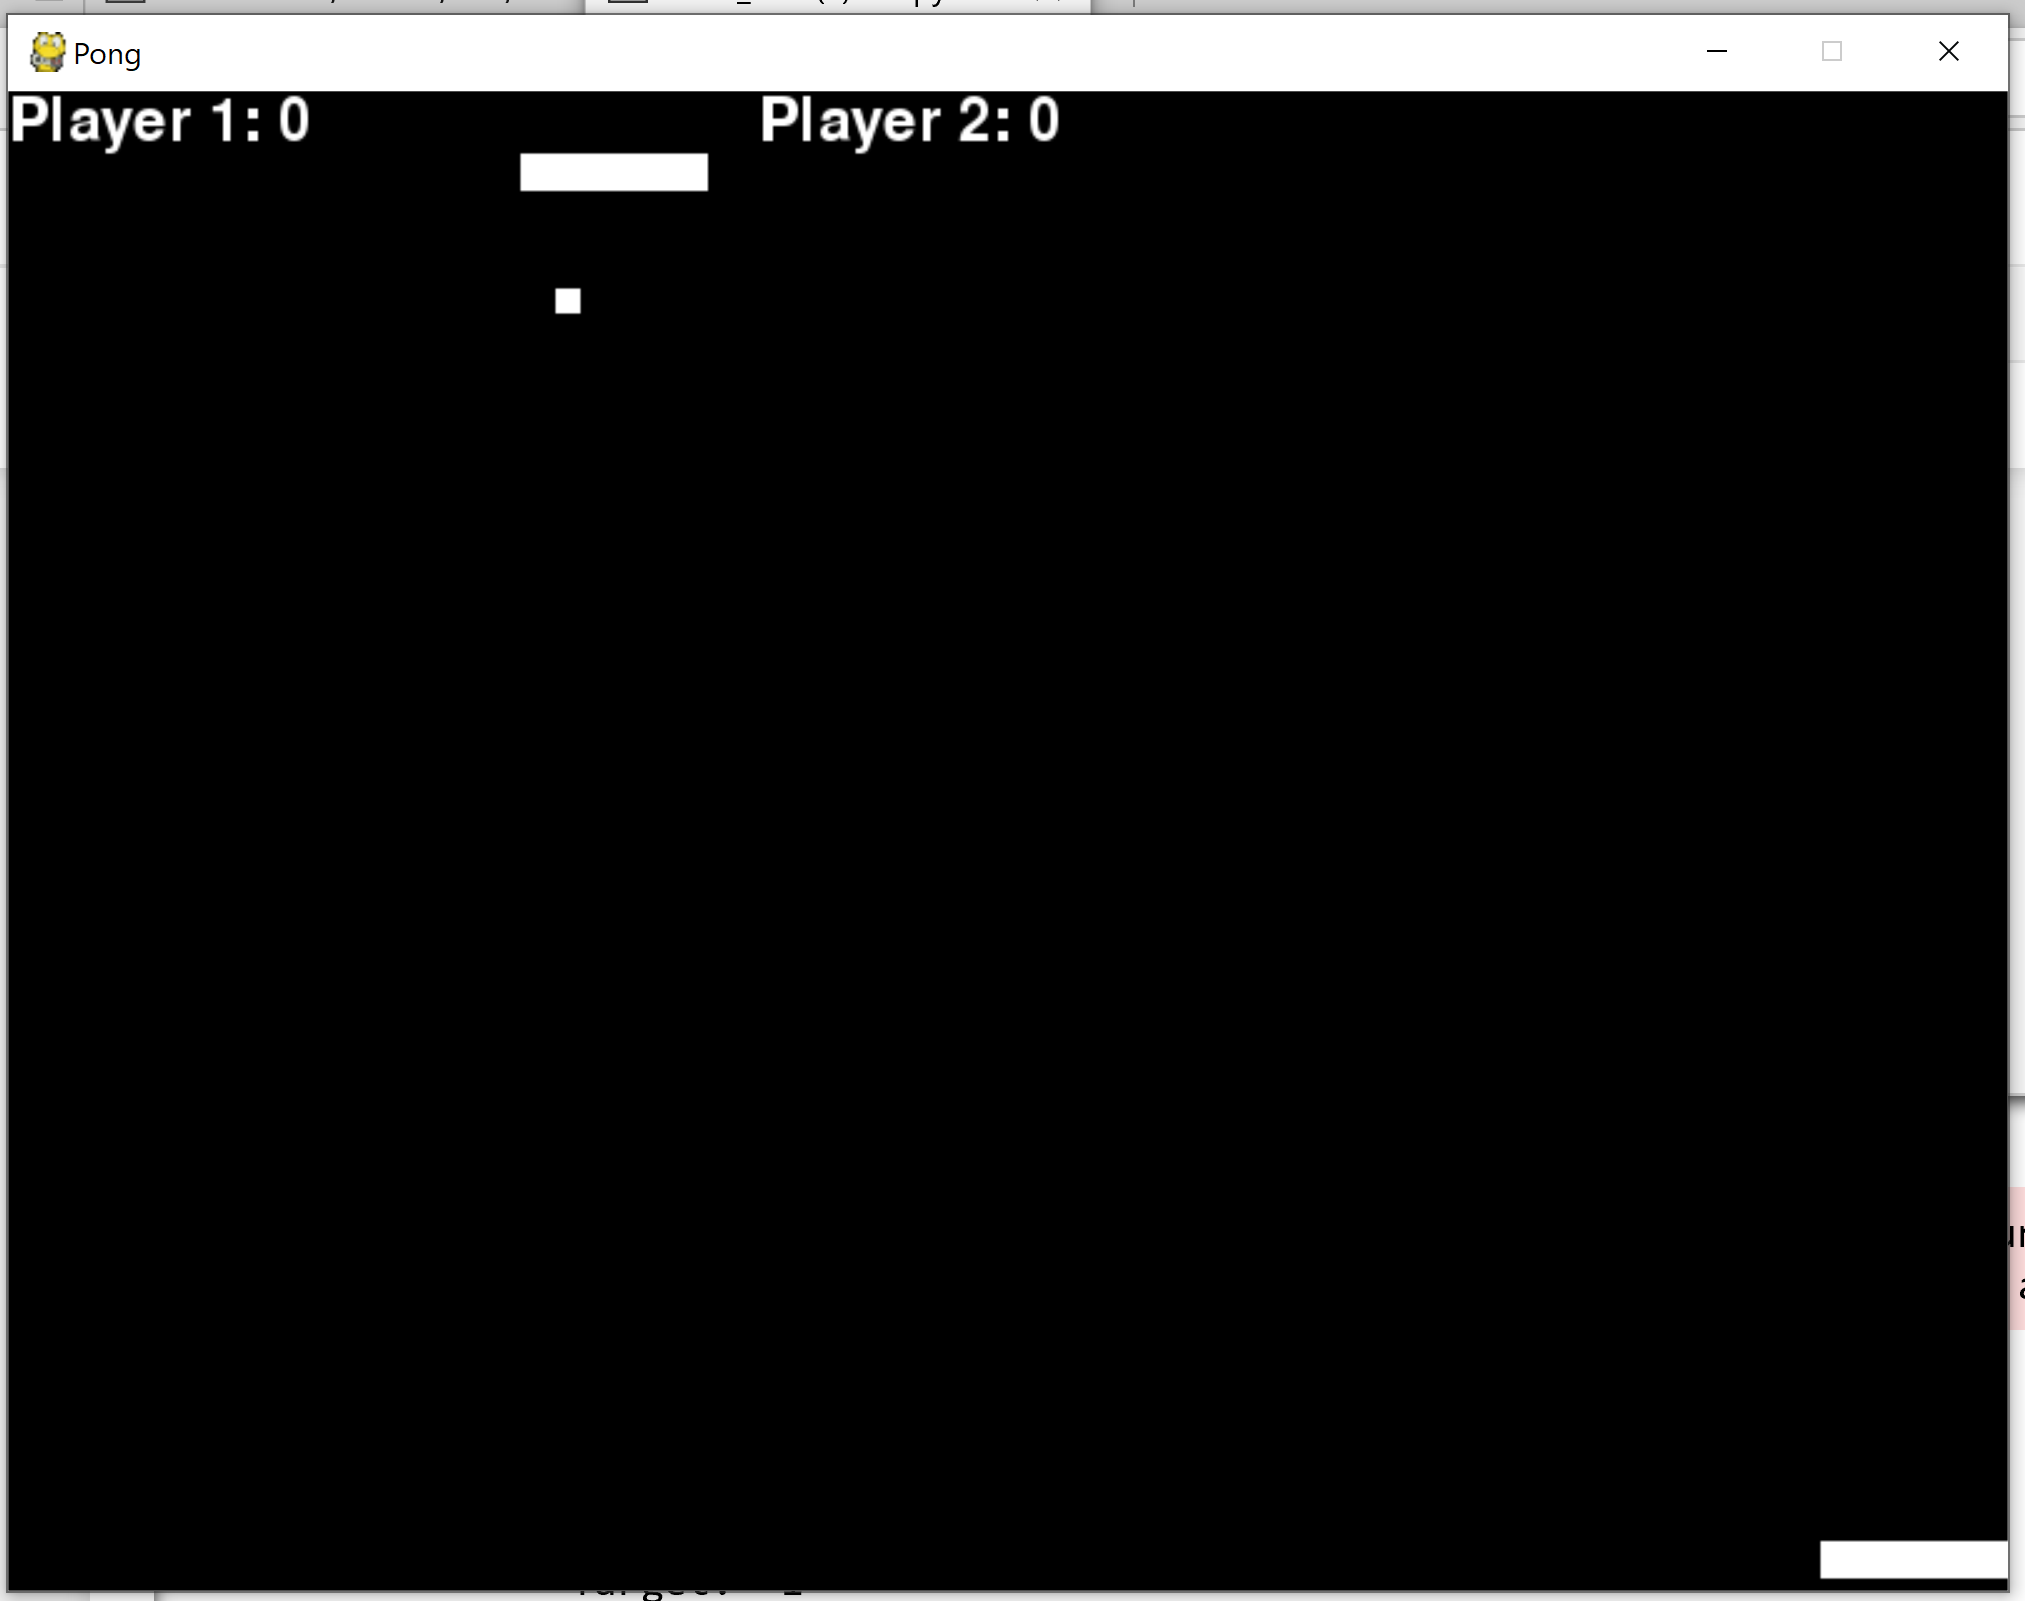

In [10]:
from IPython.display import Image
Image(filename='Not working Model1.png') 

The player 1 paddle along the bottom jams itself against one wall and stays there. The model continuously tells the paddles to move in one direction.

# **Object Detection 3D CNN**

In [0]:
#These references were good to help me think about time distribution. Code was not used.
#https://www.dezyre.com/recipes/run-basic-rnn-model-using-pytorch
#https://discuss.pytorch.org/t/timedistributed-cnn/51707

**My second network**

A major aspect that the I wanted implement in the second network was movement over time. I thought about implementing this two different ways. The first attempt was a standalone LSTM and it received shape [1,3,10,800,600]. I realized after training the network twice that the input shape was completely useless. LSTM's expects a sequence. Lack of experience made implementing a LSTM hard in the given timeframe (1 week). I moved to a time distributed CNN. I tried using code from the links above. But I realized it would be much easier to load a stack of game surfaces into a 3d tensor and accomplish a similar task. On the initial implementation of the 3D CNN I experience much of the same errors I got above. The shape, size, and parameters were all limited by the compute of colab. I blew out the RAM and GPU many times before getting something that would run. Eventually I came back to the second model on my laptop armed with more knowlegde and better perspective. Setting up the model to predict which direction the paddle should move directly was a mistake. At least in my former setup. Instead, I want the model just to predict the x position of the ball. Making the objective of the network less abstract in my opinion. 

This network receives input shape [B,C,D,H,W](1,3,16,800,600). When I revisited this model the first changes I made were to the inputs. First I took some of the input code from the first model put that in a logic function to stack the frames. Normalizing and resizing the frames is done the same way in the first model. My laptop can handle more on CPU than colab(free version). So I stacked more frames and made the network a little bit deeper. This allowed me to put a fourth convolutional layer into the model. This network is set up with Mean Squared Error Loss and similarly receives its own paddle location at the end of the forward function. This network receives the ball location as the label and model trys to predict that value. Then I implemented some simple logic on the output to tell the game whether to moved up, down or stay still on the X axis based on the predicted ball location. This model is set up to process larger input and is deeper than the first. This slowed training but not significantly. It was apparant to me this model performs much better on training than the second. The main difference between this training loop and last is how we capture the surface array data. We basically just need to capture the last 10 surface arrays as tensors in a list. Than we can stack the list to create a new tensor. Then we swap axis of the tensor using permute. I made the learning rate on this model higher so training could go faster.

My biggest complaint on this model is the accuracy function. Personally I don't find MSE accuracy to be particularly meaningly at a glance. So I kept the accuracy function the same to track how well the model follows the backboarding function. This is not a perfect measure of accuracy but it was good for comparison. The model played one long, 2 hour game against the backboarding function before I stopped the game at 8-6 (backboarding winning). Topping model "accuracy" at around 62%. I reasoned based on visual performance the models actual accuracy tracking the ball was a bit higher. 

In [4]:
class Stack_CNN(nn.Module):
    def __init__(self):
        super(Stack_CNN, self).__init__()
        self.conv1=nn.Conv3d(3,32,2)
        self.pool1=nn.MaxPool3d(3)
        self.relu1=nn.LeakyReLU()
        self.conv2=nn.Conv3d(32,96,2)
        self.relu2=nn.LeakyReLU()
        self.conv3=nn.Conv3d(96,32,2)
        self.relu3=nn.LeakyReLU()
        self.conv4=nn.Conv3d(32,3,2)
        self.relu3=nn.LeakyReLU()
        self.flat=nn.Flatten()
        self.fc1=nn.Linear(17389,5000)
        self.fc2=nn.Linear(5000,500)
        self.fc3=nn.Linear(500,1)
        

    def forward(self, x,y):
        x = self.pool1(F.leaky_relu(self.conv1(x))) 
        x = F.leaky_relu(self.conv2(x)) 
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = self.flat(x)
        x = torch.cat((x,y),dim=1)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
       
        return x

In [5]:
snn=Stack_CNN()
LR=.0001
#cnn=cnn.cuda()
optimizer = torch.optim.Adam(snn.parameters(), lr=LR)   # optimize all cnn parameters
criterion = nn.MSELoss()  

In [ ]:
#Set whole thing in training loop for pytorch
#3D CNN Training

game_count=1
num_games=3
Game_Accuracy=[]


while game_count<=num_games:
      game_count+=1
      score1 = 0
      score2 = 0
      
      # Call this function so the Pygame library can initialize itself
      pygame.init()
      
      # Create an 800x600 sized screen
      screen = pygame.display.set_mode([800, 600])
      
      # Set the title of the window
      pygame.display.set_caption('Pong')
      
      # Enable this to make the mouse disappear when over our window
      pygame.mouse.set_visible(0)
      
      # This is a font we use to draw text on the screen (size 36)
      font = pygame.font.Font(None, 36)
      
      # Create a surface we can draw on
      background = pygame.Surface(screen.get_size())
      
      # Create the ball
      ball = Ball()
      # Create a group of 1 ball (used in checking collisions)
      balls = pygame.sprite.Group()
      balls.add(ball)



      """
      #set joysticks to receive integers from neural network or deterministic. Possibly initialize to 0?
      """ 
      joystick1=0
      joystick2=0
      # Create the player paddle object
      player1 = Player(joystick1,580)
      player2 = Player(joystick2,25)

      movingsprites = pygame.sprite.Group()
      movingsprites.add(player1)
      movingsprites.add(player2)
      movingsprites.add(ball)

      clock = pygame.time.Clock()
      done = False
      exit_program = False
      i=0
      y=0
      Accuracy=0
      print("Start Game")
      moves=[]
      while not exit_program:
          i+=1
          # Clear the screen
          screen.fill(BLACK)

          for event in pygame.event.get():
              if event.type == pygame.QUIT:
                  exit_program = True

          # Stop the game if there is an imbalance of 3 points
          if abs(score1 - score2) > 3:
              done = True

          if not done:
                
              
              if i>17:
                  if pred2==pred1:
                      y+=1
                  Accuracy=y/i
                  print("Target: "+str(pred1))
                  print("Prediction: "+str(pred2))
                  print("Accuracy: "+str(Accuracy))
            
            
              """
              if i%100==0:
                print("Player position: "+str(player2.rect.x))
                print("Ball position: "+str(ball.rect.x)+", "+str(ball.rect.y))
                print(score1)
                print(score2)
              elif abs(player1.rect.y-ball.rect.y)<50:
                print("Player position: "+str(player2.rect.x))
                print("Ball position: "+str(ball.rect.x)+", "+str(ball.rect.y))
                """
              
              


          # If we are done, print game over
          if done:
              text = font.render("Game Over", 1, (200, 200, 200))
              textpos = text.get_rect(centerx=background.get_width()/2)
              textpos.top = 50
              screen.blit(text, textpos)
              
          if pygame.sprite.spritecollide(player1, balls, False):
              # The 'diff' lets you try to bounce the ball left or right depending where on the paddle you hit it
              diff = (player1.rect.x + player1.width/2) - (ball.rect.x+ball.width/2)

              # Set the ball's y position in case we hit the ball on the edge of the paddle
              ball.y = 570
              ball.bounce(diff)
              score1 += 1
              #print(score1)
              #print("Here")

          # See if the ball hits the player paddle
          if pygame.sprite.spritecollide(player2, balls, False):
              # The 'diff' lets you try to bounce the ball left or right depending where on the paddle you hit it
              diff = (player2.rect.x + player2.width/2) - (ball.rect.x+ball.width/2)

              # Set the ball's y position in case we hit the ball on the edge of the paddle
              ball.y = 40
              ball.bounce(diff)
              score2 += 1
              #print(score1)
              #print(score2)

          # Print the score
          scoreprint = "Player 1: "+str(score1)
          text = font.render(scoreprint, 1, WHITE)
          textpos = (0, 0)
          screen.blit(text, textpos)

          scoreprint = "Player 2: "+str(score2)
          text = font.render(scoreprint, 1, WHITE)
          textpos = (300, 0)
          screen.blit(text, textpos)

          # Draw Everything
          movingsprites.draw(screen)

          # Update the screen
          pygame.display.flip()

          #Update Network
          screen.lock()
          img = pygame.surfarray.array3d(screen)
          screen.unlock()
          #Resize
          img=interpolation.zoom(img,[.25,.25,1])
          #Normalize
          img = np.true_divide(img,255)
          #To Tensor and reshape
          img=torch.tensor(img)
          img=torch.unsqueeze(img,0)
          img=img.permute(0,3,1,2)
          img=img.float()
          pos=torch.tensor([player1.rect.x])
          pos=torch.unsqueeze(pos,0).float()
            
          if i<=16:
              x=moves.append(img)
          
          elif i>16:
              moves.append(img)
              moves=moves[1:]
              x=moves
              x=torch.stack(x,0)
              x=x.permute(1,2,0,3,4)
              #print(x.shape)


              #player2
              optimizer.zero_grad()
              # forward + backward + optimize
              label=ball.rect.x
              print(label)
              label = torch.tensor([label], dtype=torch.float64)
              pos=torch.tensor([player2.rect.x])
              pos=torch.unsqueeze(pos,0).float()
              pred2=snn(x,pos).type(torch.float64)  
              loss = criterion(pred2, label)
              loss.backward()
              optimizer.step()
              #update positions
              print(pred2[0][0])
              if pred2[0][0]>player2.rect.x:
                  pred2=1
              elif pred2[0][0]<player2.rect.x:
                  pred2=-1
              else:
                  pred2=0
              player2.update(pred2)
          #player1 backboard
          pred1=Backboard(player1,ball)
          player1.update(pred1)
          ball.update()
              
           
              
              
              
          if done:
            print("Gameover")
            Game_Accuracy.append(Accuracy)
            #clock.tick(5)
            if score1>score2:
                print("Player 1 Score: "+str(score1-1))
                print("Player 2 Score: "+str(score2))
            elif score1<score2:
                print("Player 1 Score: "+str(score1))
                print("Player 2 Score: "+str(score2-1))
            #print(loss)
            #pygame.quit()
            exit_program = True
              

          
          
              

          

In [78]:
torch.save(snn,'3DCNN.ml')

C:\Users\John Galpin\anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Stack_CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\John Galpin\anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv3d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\John Galpin\anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MaxPool3d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Test Model 2

In [79]:
paddle2=torch.load('3DCNN.ml')
paddle2.eval()

Stack_CNN(
  (conv1): Conv3d(3, 32, kernel_size=(2, 2, 2), stride=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (relu1): LeakyReLU(negative_slope=0.01)
  (conv2): Conv3d(32, 96, kernel_size=(2, 2, 2), stride=(1, 1, 1))
  (relu2): LeakyReLU(negative_slope=0.01)
  (conv3): Conv3d(96, 32, kernel_size=(2, 2, 2), stride=(1, 1, 1))
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv3d(32, 3, kernel_size=(2, 2, 2), stride=(1, 1, 1))
  (flat): Flatten()
  (fc1): Linear(in_features=17389, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=1, bias=True)
)

The first model gave me a lot of lessons learned but hope was running low. My second model mentioned above  was originally an LSTM RNN. The second model was definitely not set up correctly as an RNN. After getting the first model to acceptable failure. I reasoned that something closer to object detection CNN could be better suited for this task. When I initially tested the second model in validation I saw a glimmer of hope. The model output actually caused the paddle to shuffle back and forth in a semi coherent manner. Meaning we are actually getting more than one output with logic. A positive sign. As the game progressed I realized the model was actually performing okay. It didn't perfectly follow the ball but it did exhibit that kind of behavior as the ball got closer to the paddle. The model matched the back boarding function until three points. The model after being trained for one game lost 7 to 3. While the model was never going to win I call this a success!

In [80]:
#Set whole thing in training loop for pytorch
#3D CNN Training

game_count=1
num_games=1
Game_Accuracy


while game_count<=num_games:
      game_count+=1
      score1 = 0
      score2 = 0
      
      # Call this function so the Pygame library can initialize itself
      pygame.init()
      
      # Create an 800x600 sized screen
      screen = pygame.display.set_mode([800, 600])
      
      # Set the title of the window
      pygame.display.set_caption('Pong')
      
      # Enable this to make the mouse disappear when over our window
      pygame.mouse.set_visible(0)
      
      # This is a font we use to draw text on the screen (size 36)
      font = pygame.font.Font(None, 36)
      
      # Create a surface we can draw on
      background = pygame.Surface(screen.get_size())
      
      # Create the ball
      ball = Ball()
      # Create a group of 1 ball (used in checking collisions)
      balls = pygame.sprite.Group()
      balls.add(ball)



      """
      #set joysticks to receive integers from neural network or deterministic. Possibly initialize to 0?
      """ 
      joystick1=0
      joystick2=0
      # Create the player paddle object
      player1 = Player(joystick1,580)
      player2 = Player(joystick2,25)

      movingsprites = pygame.sprite.Group()
      movingsprites.add(player1)
      movingsprites.add(player2)
      movingsprites.add(ball)

      clock = pygame.time.Clock()
      done = False
      exit_program = False
      i=0
      y=0
      Accuracy=0
      print("Start Game")
      moves=[]
      while not exit_program:
          i+=1
          # Clear the screen
          screen.fill(BLACK)

          for event in pygame.event.get():
              if event.type == pygame.QUIT:
                  exit_program = True

          # Stop the game if there is an imbalance of 3 points
          if abs(score1 - score2) > 3:
              done = True

          if not done:
                
              
              if i>16:
                  if pred2==pred1:
                      y+=1
                  Accuracy=y/i
                  print("Target: "+str(pred1))
                  print("Prediction: "+str(pred2))
                  print("Accuracy: "+str(Accuracy))
            
            
              """
              if i%100==0:
                print("Player position: "+str(player2.rect.x))
                print("Ball position: "+str(ball.rect.x)+", "+str(ball.rect.y))
                print(score1)
                print(score2)
              elif abs(player1.rect.y-ball.rect.y)<50:
                print("Player position: "+str(player2.rect.x))
                print("Ball position: "+str(ball.rect.x)+", "+str(ball.rect.y))
                """
              
              


          # If we are done, print game over
          if done:
              text = font.render("Game Over", 1, (200, 200, 200))
              textpos = text.get_rect(centerx=background.get_width()/2)
              textpos.top = 50
              screen.blit(text, textpos)
              
          if pygame.sprite.spritecollide(player1, balls, False):
              # The 'diff' lets you try to bounce the ball left or right depending where on the paddle you hit it
              diff = (player1.rect.x + player1.width/2) - (ball.rect.x+ball.width/2)

              # Set the ball's y position in case we hit the ball on the edge of the paddle
              ball.y = 570
              ball.bounce(diff)
              score1 += 1
              #print(score1)
              #print("Here")

          # See if the ball hits the player paddle
          if pygame.sprite.spritecollide(player2, balls, False):
              # The 'diff' lets you try to bounce the ball left or right depending where on the paddle you hit it
              diff = (player2.rect.x + player2.width/2) - (ball.rect.x+ball.width/2)

              # Set the ball's y position in case we hit the ball on the edge of the paddle
              ball.y = 40
              ball.bounce(diff)
              score2 += 1
              #print(score1)
              #print(score2)

          # Print the score
          scoreprint = "Player 1: "+str(score1)
          text = font.render(scoreprint, 1, WHITE)
          textpos = (0, 0)
          screen.blit(text, textpos)

          scoreprint = "Player 2: "+str(score2)
          text = font.render(scoreprint, 1, WHITE)
          textpos = (300, 0)
          screen.blit(text, textpos)

          # Draw Everything
          movingsprites.draw(screen)

          # Update the screen
          pygame.display.flip()

          #Update Network
          screen.lock()
          img = pygame.surfarray.array3d(screen)
          screen.unlock()
          #Resize
          img=interpolation.zoom(img,[.25,.25,1])
          #Normalize
          img = np.true_divide(img,255)
          #To Tensor and reshape
          img=torch.tensor(img)
          img=torch.unsqueeze(img,0)
          img=img.permute(0,3,1,2)
          img=img.float()
          pos=torch.tensor([player1.rect.x])
          pos=torch.unsqueeze(pos,0).float()
            
          if i<=16:
              x=moves.append(img)
          
          elif i>16:
              moves.append(img)
              moves=moves[1:]
              x=moves
              x=torch.stack(x,0)
              x=x.permute(1,2,0,3,4)
              #print(x.shape)


              #player2
              label=ball.rect.x
              print(label)
              label = torch.tensor([label], dtype=torch.float64)
              pos=torch.tensor([player2.rect.x])
              pos=torch.unsqueeze(pos,0).float()
              pred2=paddle2(x,pos).type(torch.float64)  
              print(pred2[0][0])
              if pred2[0][0]>player2.rect.x:
                  pred2=1
              elif pred2[0][0]<player2.rect.x:
                  pred2=-1
              else:
                  pred2=0
              player2.update(pred2)
          #player1 backboard
          player1.update(pred1)
          pred1=Backboard(player1,ball)
          ball.update()
              
           
              
              
              
          if done:
            print("Gameover")
            Game_Accuracy.append(Accuracy)
            #clock.tick(5)
            if score1>score2:
                print("Player 1 Score: "+str(score1-1))
                print("Player 2 Score: "+str(score2))
            elif score1<score2:
                print("Player 1 Score: "+str(score1))
                print("Player 2 Score: "+str(score2-1))
            #print(loss)
            #pygame.quit()
            exit_program = True
              

          
          
              

          

Start Game
Target: 1
Prediction: tensor([[275.4424]], dtype=torch.float64, grad_fn=<CopyBackwards>)
Accuracy: 0.0
562
tensor(204.8382, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.05555555555555555
568
tensor(201.3928, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.05263157894736842
573
tensor(194.9222, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.05
579
tensor(190.2749, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.09523809523809523
585
tensor(184.8693, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.09090909090909091
590
tensor(179.4614, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.08695652173913043
596
tensor(174.2249, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.08333333333333333
602
tensor(166.0524, dtype=torch.float

647
tensor(178.1954, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.38823529411764707
641
tensor(170.9398, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.38372093023255816
636
tensor(166.3683, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.39080459770114945
630
tensor(163.4315, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.3977272727272727
624
tensor(165.7512, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.39325842696629215
619
tensor(170.3391, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.3888888888888889
613
tensor(189.7422, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.38461538461538464
607
tensor(210.3679, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.391304347826087
602
tensor(232.468

87
tensor(243.5875, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.41830065359477125
79
tensor(265.7803, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4155844155844156
70
tensor(287.5746, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.41935483870967744
61
tensor(311.9371, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4166666666666667
52
tensor(334.1229, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4140127388535032
44
tensor(352.1014, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.41139240506329117
35
tensor(372.5222, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 0
Prediction: 1
Accuracy: 0.4088050314465409
26
tensor(395.2181, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.40625
18
tensor(400.7049, dtype=torch.float64, g

489
tensor(304.2733, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.416289592760181
497
tensor(280.3425, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4144144144144144
506
tensor(263.6990, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4170403587443946
515
tensor(243.4781, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.41517857142857145
524
tensor(221.6540, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.41333333333333333
532
tensor(201.8131, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.41150442477876104
541
tensor(176.3786, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.40969162995594716
550
tensor(154.3712, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.41228070175438597
558
tensor(140.653

506
tensor(199.1354, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4083044982698962
497
tensor(207.4028, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4068965517241379
489
tensor(223.7498, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.40893470790378006
480
tensor(245.1991, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4075342465753425
471
tensor(265.7647, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4061433447098976
462
tensor(276.5697, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.40476190476190477
454
tensor(290.6640, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4033898305084746
445
tensor(303.1247, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.40540540540540543
436
tensor(303.4298, d

70
tensor(268.4143, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.41456582633053224
79
tensor(243.6580, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4134078212290503
87
tensor(225.8454, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.41225626740947074
96
tensor(207.2265, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4111111111111111
105
tensor(192.2171, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 0
Prediction: -1
Accuracy: 0.4099722991689751
114
tensor(180.3045, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4088397790055249
122
tensor(164.2309, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.40771349862258954
131
tensor(158.3251, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.40934065934065933
140
tensor(157.4113, d

663
tensor(208.7276, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4188235294117647
672
tensor(231.2310, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.42018779342723006
681
tensor(252.6864, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4215456674473068
689
tensor(275.5396, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4205607476635514
698
tensor(299.9198, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4219114219114219
707
tensor(319.4800, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4232558139534884
716
tensor(336.9852, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4245939675174014
724
tensor(358.2854, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.42592592592592593
733
tensor(361.6642, dtype=to

332
tensor(356.7072, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4178498985801217
323
tensor(321.6632, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4190283400809717
314
tensor(295.4633, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4202020202020202
305
tensor(274.7484, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 0
Prediction: -1
Accuracy: 0.41935483870967744
297
tensor(261.7810, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.42052313883299797
288
tensor(253.8070, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.42168674698795183
279
tensor(244.5995, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.42084168336673344
271
tensor(238.9383, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.422
262
tensor(230.7784, dtype=

244
tensor(425.0112, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4295900178253119
253
tensor(415.1685, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4306049822064057
262
tensor(390.0691, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.42984014209591476
271
tensor(372.5321, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.42907801418439717
279
tensor(351.0050, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4283185840707965
288
tensor(318.2732, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4275618374558304
297
tensor(291.6358, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.42857142857142855
305
tensor(267.6353, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4278169014084507
314
tensor(238.1266,

659
tensor(219.8791, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.43879173290937995
649
tensor(205.9761, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4396825396825397
639
tensor(193.4452, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4405705229793978
628
tensor(182.4745, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.44145569620253167
618
tensor(172.5845, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4423380726698262
608
tensor(168.7088, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4416403785488959
598
tensor(167.7004, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.44251968503937006
588
tensor(169.3131, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.44339622641509435
577
tensor(17

tensor(193.0561, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4468390804597701
26
tensor(209.1023, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.44619799139167865
36
tensor(228.1130, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4469914040114613
46
tensor(245.5179, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.44778254649499283
57
tensor(265.1815, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.44857142857142857
67
tensor(288.5441, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.44935805991440797
77
tensor(307.5609, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.45014245014245013
87
tensor(326.2857, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.44950213371266
98
tensor(350.9516, dtype=torch.float6

721
tensor(481.8248, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.45157068062827227
732
tensor(478.0892, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4522875816993464
743
tensor(442.6708, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.45300261096605743
754
tensor(410.6928, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.45371577574967403
765
tensor(373.5439, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4544270833333333
775
tensor(332.0385, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4538361508452536
786
tensor(294.6382, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.45324675324675323
797
tensor(261.6038, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.45265888456549935
786
tensor(235.8681, dty

135
tensor(459.8489, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.44591346153846156
124
tensor(428.0005, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.44537815126050423
113
tensor(378.6535, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4448441247002398
102
tensor(339.9230, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.44550898203592815
91
tensor(303.5412, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4461722488038278
80
tensor(271.7056, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 0
Prediction: -1
Accuracy: 0.44563918757467147
70
tensor(247.0649, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.44630071599045346
59
tensor(235.2595, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4469606674612634
48
tensor(225.7467,

650
tensor(363.4418, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.45666666666666667
663
tensor(368.3723, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4572697003329634
676
tensor(376.4849, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.45787139689578715
689
tensor(368.3350, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4584717607973422
702
tensor(340.0074, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4579646017699115
715
tensor(312.4688, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4574585635359116
727
tensor(286.8759, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.45695364238410596
740
tensor(254.6898, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4564498346196251
753
tensor(233.2915, dtyp

60
tensor(196.7003, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.45041322314049587
47
tensor(184.0911, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.45098039215686275
34
tensor(182.5591, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4515463917525773
21
tensor(180.6357, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.45211122554067973
8
tensor(175.5181, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.45267489711934156
-4
tensor(180.6187, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.45323741007194246
8
tensor(186.7984, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4527720739219713
21
tensor(189.6588, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4533333333333333
34
tensor(205.9254, dtyp

779
tensor(368.1896, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4584942084942085
766
tensor(400.0654, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.45901639344262296
753
tensor(410.2850, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4595375722543353
740
tensor(415.3012, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4600577478344562
727
tensor(422.0226, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.46057692307692305
715
tensor(400.2666, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4601344860710855
702
tensor(372.0066, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4596928982725528
689
tensor(348.0524, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.46021093000958774
676
tensor(310.0876, dtyp

72
tensor(263.0067, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4614687216681777
85
tensor(239.0595, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.46105072463768115
98
tensor(222.7443, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4606334841628959
111
tensor(208.1415, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4602169981916817
124
tensor(195.7683, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4598012646793135
137
tensor(184.5828, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.45938628158844763
149
tensor(170.2402, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4598737601442741
162
tensor(163.1974, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4594594594594595
175
tensor(160.3984, dty

638
tensor(168.9019, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4654141759180188
625
tensor(175.0634, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4658703071672355
612
tensor(181.5106, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.46547314578005117
599
tensor(200.7674, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.46507666098807493
586
tensor(225.3236, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4646808510638298
573
tensor(247.8407, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4642857142857143
560
tensor(267.9534, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 0
Prediction: 1
Accuracy: 0.4638912489379779
548
tensor(288.5677, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4634974533106961
535
tensor(311.5887, 

214
tensor(311.4094, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.46365105008077545
227
tensor(329.1043, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.46408393866020986
239
tensor(352.6904, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4645161290322581
252
tensor(358.5988, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4649476228847704
265
tensor(357.0834, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.46537842190016104
278
tensor(357.2238, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4658085277554304
291
tensor(334.7388, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4654340836012862
304
tensor(300.5337, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4650602409638554
316
tensor(271.8808, dtype=

496
tensor(268.2595, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4647779479326187
483
tensor(282.9095, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.46442234123947973
471
tensor(300.2987, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4648318042813456
458
tensor(312.3535, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4644766997708174
445
tensor(317.3746, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.46412213740458014
432
tensor(325.6306, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.463768115942029
419
tensor(327.8531, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4641768292682927
406
tensor(310.1090, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4645849200304646
394
tensor(294.7382, d

368
tensor(282.4875, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.46797671033478894
381
tensor(290.7090, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.46763636363636363
394
tensor(283.3915, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4680232558139535
406
tensor(289.4700, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.46768336964415397
419
tensor(284.8270, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4680696661828737
432
tensor(288.8093, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4677302393038434
445
tensor(281.0337, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4681159420289855
458
tensor(287.0001, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4677769732078204
471
tensor(278.7184, dtyp

tensor(170.6780, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4677307425399028
325
tensor(161.3807, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4680998613037448
312
tensor(162.4482, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.46846846846846846
298
tensor(162.6215, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.46883656509695293
284
tensor(165.4536, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4692041522491349
271
tensor(176.6313, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.46957123098201936
257
tensor(185.3141, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4692467173462336
244
tensor(203.8586, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.46892265193370164
230
tensor(225.039

556
tensor(359.4062, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4711729622266402
569
tensor(374.6418, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.47086092715231787
583
tensor(372.9891, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.47121111846459296
596
tensor(365.0378, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.47156084656084657
610
tensor(362.9736, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.47191011235955055
623
tensor(340.2927, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4715984147952444
637
tensor(310.3104, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.47128712871287126
650
tensor(286.4042, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.470976253298153
664
tensor(254.6687, dty

510
tensor(181.4228, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4686112872542803
508
tensor(184.2486, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.46894803548795944
519
tensor(184.9639, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.46928435718809375
521
tensor(202.9650, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.46962025316455697
523
tensor(222.6478, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4693232131562302
525
tensor(239.5025, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4696586599241466
527
tensor(257.7101, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4693619709412508
530
tensor(276.2751, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4696969696969697
532
tensor(295.7930, dty

629
tensor(314.4718, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4723404255319149
632
tensor(285.5938, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.47205346294046174
635
tensor(252.7070, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 0
Prediction: -1
Accuracy: 0.47176684881602915
637
tensor(226.5118, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.47148058252427183
640
tensor(208.7756, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.47180109157064887
643
tensor(198.3045, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4715151515151515
646
tensor(186.1165, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4718352513628104
648
tensor(179.1918, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4715496368038741
651
tensor(172.63

741
tensor(219.6285, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.47227086981903094
737
tensor(239.8773, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4725787631271879
732
tensor(256.7785, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4728862973760933
728
tensor(271.9717, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4731934731934732
724
tensor(291.2701, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.47291788002329643
720
tensor(306.4786, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4732246798603027
716
tensor(320.6568, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.47294938917975565
711
tensor(344.2691, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.47325581395348837
707
tensor(351.7155, dtype

453
tensor(186.9512, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.47247191011235956
454
tensor(174.0347, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.47220662549129705
456
tensor(164.8204, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4719416386083053
457
tensor(157.0723, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4722378014582165
458
tensor(152.7238, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.47197309417040356
460
tensor(155.1711, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4722689075630252
461
tensor(158.9065, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4720044792833147
463
tensor(169.8921, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.47174034695019584
464
tensor(192.88

559
tensor(221.2862, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4742826204656199
564
tensor(236.1933, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4745670995670996
568
tensor(248.0309, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4743104380746349
573
tensor(260.8925, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4745945945945946
577
tensor(277.5774, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.47487844408427876
582
tensor(293.7269, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.474622030237581
586
tensor(310.8221, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4749055585536967
591
tensor(335.6412, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.47518878101402373
596
tensor(348.7010, dtype=to

234
tensor(301.7256, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.47335423197492166
229
tensor(292.5722, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.47362924281984337
225
tensor(279.9796, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4733820459290188
220
tensor(267.4043, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4736567553468962
215
tensor(258.9791, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 0
Prediction: -1
Accuracy: 0.47340980187695514
211
tensor(243.3685, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.47368421052631576
206
tensor(231.1397, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4734375
201
tensor(225.7701, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4737116085372202
197
tensor(218.5047, dty

765
tensor(386.0209, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4772956609485368
766
tensor(378.8745, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.47755925365607665
767
tensor(350.9664, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.47731854838709675
767
tensor(324.5483, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4770780856423174
768
tensor(298.2992, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4768378650553877
768
tensor(264.9250, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4765978862606945
769
tensor(242.7076, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.47635814889336014
769
tensor(224.4257, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4761186525892408
772
tensor(209.1143, dt

668
tensor(136.2624, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4751219512195122
666
tensor(134.7773, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.47489029741589467
664
tensor(142.2740, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.47514619883040937
661
tensor(150.9014, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4754018509498295
659
tensor(164.9188, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4756572541382668
656
tensor(194.6747, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4754257907542579
654
tensor(221.7407, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.47568093385214005
263
tensor(249.9184, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.47544968400583376
268
tensor(274.3477

596
tensor(287.9240, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4752007557864903
598
tensor(318.6492, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4749763928234183
595
tensor(342.8400, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4752241623407268
592
tensor(369.3842, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.475
590
tensor(404.4479, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 0
Prediction: 1
Accuracy: 0.47477604903347476
587
tensor(417.4330, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.47455230914231855
584
tensor(423.9838, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.47479981158737633
582
tensor(436.5254, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4745762711864407
579
tensor(419.1504, dtype=torch.float

547
tensor(185.9210, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.47551487414187643
550
tensor(174.3422, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.47529734675205854
553
tensor(163.7667, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.47553726566072246
556
tensor(154.6263, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4753199268738574
560
tensor(152.1805, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 0
Prediction: -1
Accuracy: 0.4751027866605756
563
tensor(150.7325, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4748858447488584
566
tensor(153.0434, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4751255134641716
569
tensor(162.5876, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.47536496350364965
572
tensor(182.9795

674
tensor(254.0287, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4755772646536412
672
tensor(275.1836, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4758100310696849
669
tensor(304.9913, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4755989352262644
667
tensor(327.8104, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.47583148558758315
665
tensor(352.7268, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.47562056737588654
663
tensor(388.1792, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.47540983606557374
661
tensor(402.0959, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.47564216120460584
659
tensor(409.9546, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4754316069057105
657
tensor(422.5874, dt

tensor(307.9656, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.47520482966796035
479
tensor(269.5880, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.47543103448275864
484
tensor(234.2726, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4752261956053425
489
tensor(212.2303, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.47502153316106804
494
tensor(197.4680, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4752475247524752
498
tensor(186.7947, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.4750430292598967
503
tensor(180.2572, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: -1
Accuracy: 0.47483870967741937
508
tensor(173.4595, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: -1
Accuracy: 0.4750644883920894
512
tensor(168.5159, 

244
tensor(180.2462, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4752724224643755
242
tensor(202.5592, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.47549224968579806
239
tensor(222.5362, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4752931323283082
237
tensor(245.0152, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4755127668480536
235
tensor(264.1753, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.47531380753138075
233
tensor(286.1962, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: 1
Prediction: 1
Accuracy: 0.4755332496863237
231
tensor(317.0749, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4753344481605351
228
tensor(337.7752, dtype=torch.float64, grad_fn=<SelectBackward>)
Target: -1
Prediction: 1
Accuracy: 0.4751358127872963
226
tensor(362.6046, dtyp

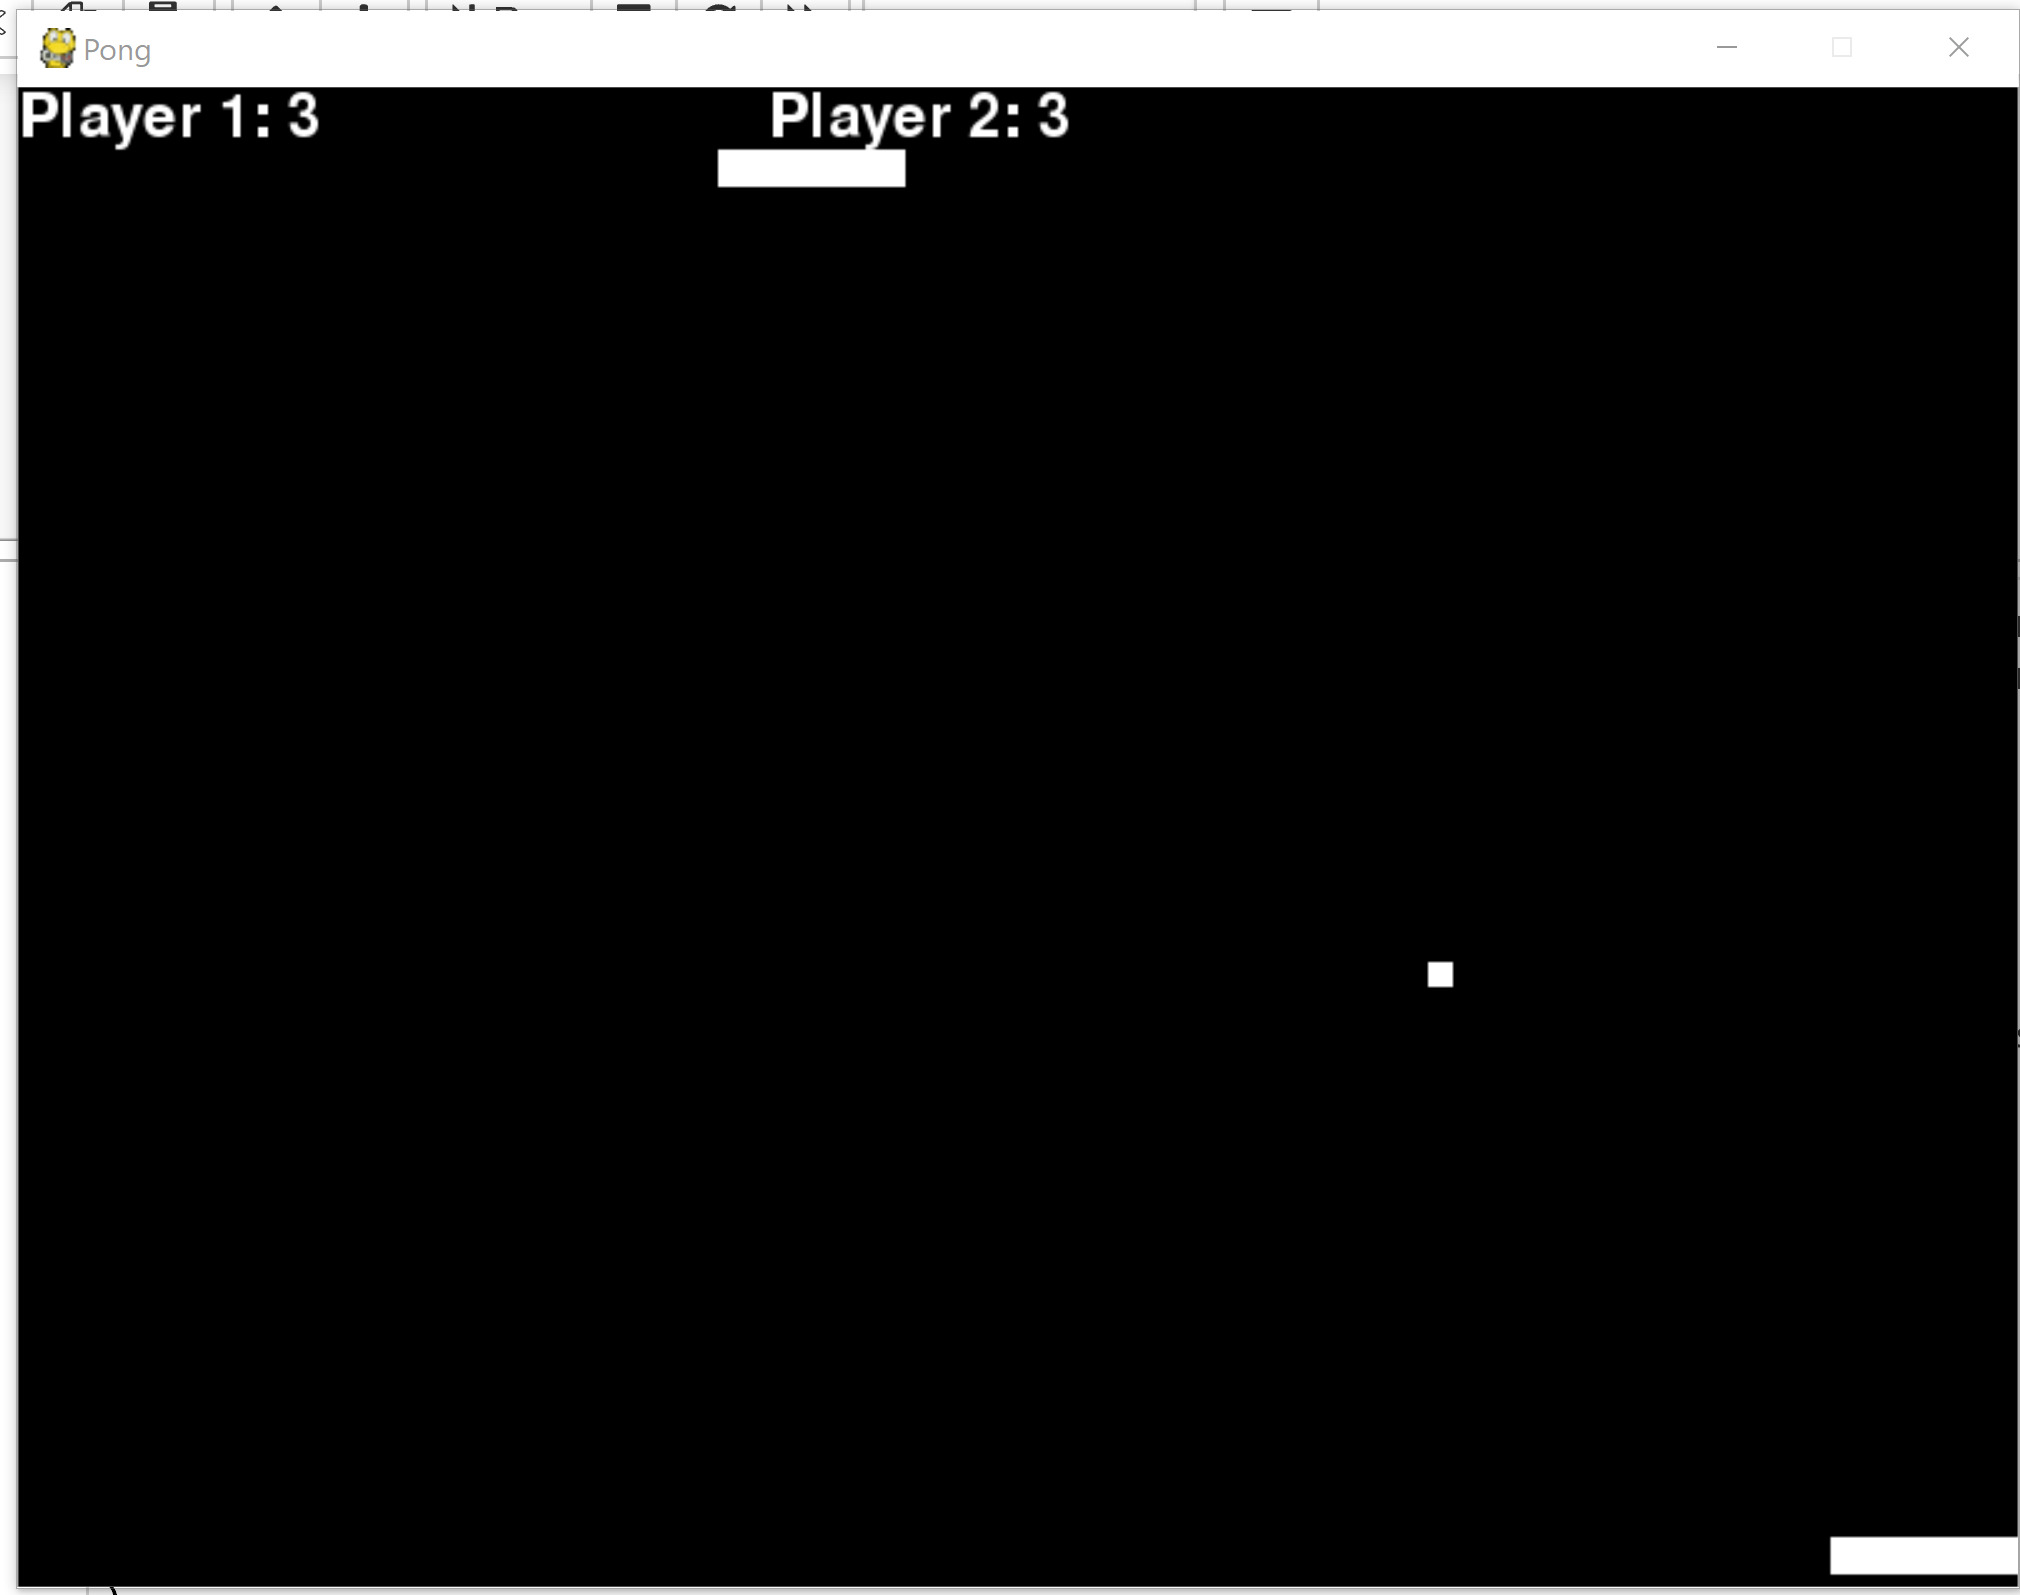

In [1]:
#from IPython.display import Image
Image(filename='Working Model2.png') 

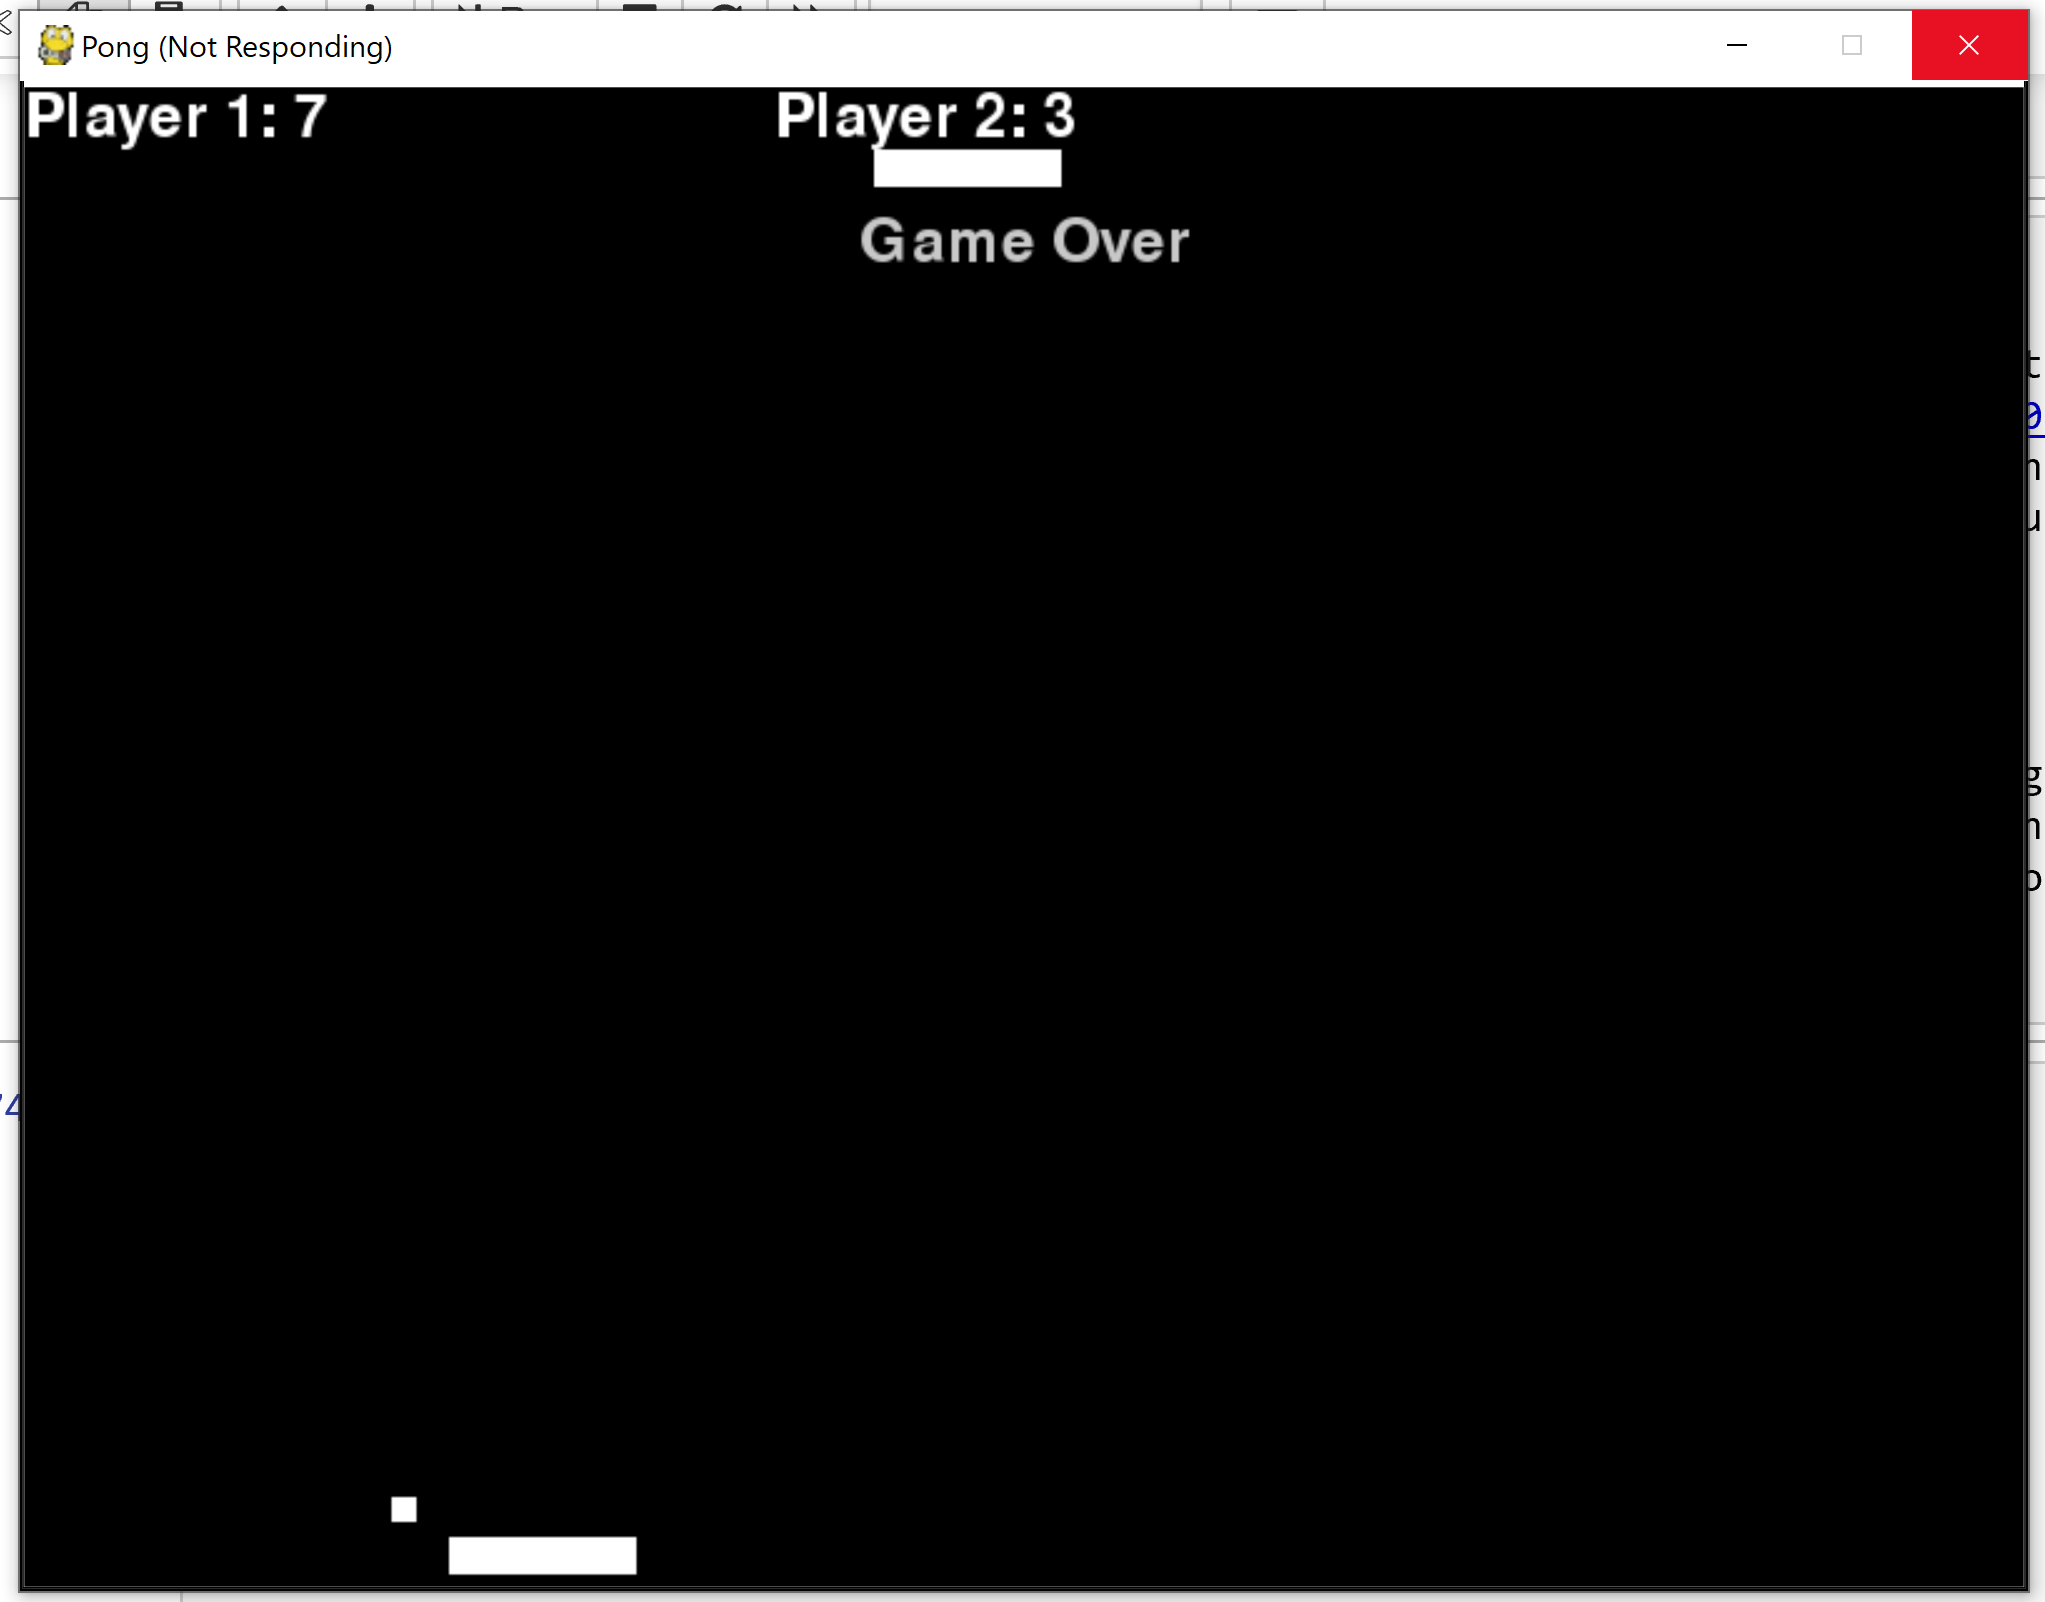

In [2]:
Image(filename='Working Model2 Final.png') 

Player 2 along the top is controlled by the model and player 1 by the labeling function.

# **Conclusion: What I learned**



1. Real time computation is important for live applications.

During training, naturally the game lags as the network does its computations. This problem is greatly exacerbated without good computational resources. Google colab cannot fully run pygames display module. So I would never be able to see the simulation happening first had. I started testing the code on my local machine. This gave me a better respect for the problem computation time. For one, I had not enabled GPU usage on my local machine. Second, I hadn't run the code with a display yet. The lag during training was truly horrendous. Training was particularly slow for the second network. During validation the speed of the game greatly improved. Long story short, if application needs to run in real time, computational complexity and physical hardware are important factors.


2. The network does very little to check your input. 

I spent half the time I was writing code training a network with bad data. Pygame pong runs in a loop. Each frame the display must be rewritten. Instead of feeding the network the display with all the objects all it got was a black screen. I didn't realize this until validation when the network was outputting bad results. Even then it took me awhile to figure out. During training I was feeding the network a batch of one. The resulting models were useless during validation. To rectify the problem I outputted the frame at various points to figure out the best point to access the display variable as an array. Eventually I found the correct spot at the end of the loop when the entire diplay is updated. Even then, I had to run the model on my local machine. I discovered that pygame wasn't rendering correctly in google colab. Even though 95% of my code was good, that 5% made my entire experiment useless. Resizing the input frames and normalizing my data also made a huge impact on performance. 

3. Dimensionality of your input data affect what you can do with your network.

Building my second network I realized very quickly that it would require a lot more horsepower to run. The more complex the layers got the bigger the input had to be. I wanted to do a time phased network. That could mean a lot of things. I lacked the time and understanding to implement an LSTM model. That didn't stop me from trying and failing. The input was all wrong and the network wasn't set up to take sequential images. Eventually I moved to 3D convulutional model which took a sequence of frames that were stacked to together. Running the network in colab I could very quickly run out of RAM. 15 frames stacked were to many and 5 was too little. For round number I went with 10, making the shape of my input [1,3,16,800,600]. I was so worried about the color channel I quickly forgot about my other dimensions. Once on my laptop having 16 frames as my 3rd dimension allowed me to use larger kernels and make use of pooling layers. Those 16 frames would quickly drop out when dimensionality reduction was done on the input. The shape of your input is just as important as the model construction. 

4. Model performance will be bad with poorly defined objectives

There were a lot of things contributing to my first model running poorly. A lot of them lived in the code but another big one was the thought process behind it. I fixed all the mistakes outlined above. But, I believe what made my second model ultimately successful was changing its objective to something more reasonable. I wanted to model to move the paddle around but there were steps before that. The questions I really need to ask was where is the ball? Without that information the paddle was going to move incoherently. The logic to moved the paddle was actually less important. The first model was completely useless so there was no point in running a third test where the models compete against eachother.


Thanks for reading!

